In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from lightkurve import search_lightcurvefile

In [4]:
star = 'AB Dor'
lcf = search_lightcurvefile(star, mission='TESS').download_all()

In [6]:
lc = lcf.PDCSAP_FLUX.stitch()

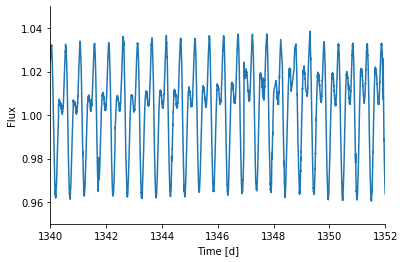

In [17]:
plt.plot(lc.time, lc.flux)
plt.xlim([1340, 1352])
plt.ylim([0.95, 1.05])
for sp in 'right top'.split():
    plt.gca().spines[sp].set_visible(False)
    
plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.savefig('plots/abdor.png', bbox_inches='tight', dpi=250)

In [19]:
t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

In [45]:
max_time = 1346 #1352
min_time = 1340
skip = 5

t1, f1, e1 = t[(t < max_time) & (t > min_time)][::skip], f[(t < max_time) & (t > min_time)][::skip], e[(t < max_time) & (t > min_time)][::skip]

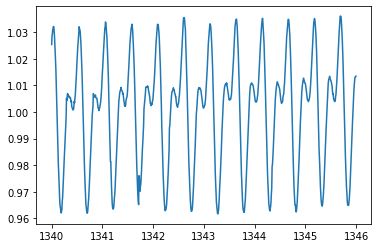

In [46]:
plt.plot(t1, f1)

In [47]:
import pymc3 as pm
from pymc3.smc import sample_smc
import theano
from corner import corner

e1_tt = theano.shared(np.asarray(e1, dtype=theano.config.floatX), name='e1')

In [ ]:
n_spots = 5

with pm.Model(name=f'{n_spots}') as model1:

    f0 = pm.Uniform("f0", lower=0, upper=1)
    nu = pm.Uniform("nu", lower=1, upper=5)    
    spot_model = 1 + f0
    eq_period = pm.Uniform("P_eq", lower=0.4, upper=0.6)
    shear = pm.Uniform("shear", lower=0.01, upper=0.2)
    
    for spot_ind in range(n_spots):
        rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.01, upper=0.4)
        lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
        latitude_cutoff = 10
        lat = pm.Uniform(f"lat_{spot_ind}", lower=np.radians(latitude_cutoff), upper=np.radians(180-latitude_cutoff))
        period = eq_period / (1 - shear * pm.math.sin(lat - np.pi/2)**2)

        spot_position_y = (np.pi/2 - lat) / (np.pi / 2)
        spot_position_x = pm.math.sqrt(1 - spot_position_y**2) * pm.math.cos(2 * np.pi / period * (t1 - t1.mean()) - lon)
        spot_position_z = pm.math.sqrt(1 - spot_position_y**2) * pm.math.sin(2 * np.pi / period * (t1 - t1.mean()) - lon)
        rsq = spot_position_x**2 + spot_position_y**2
        contrast = 0.7
        spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)
    
    pm.StudentT("obs", mu=spot_model, nu=nu,
                sigma=e1_tt,
                observed=f1)
    
    trace1 = sample_smc(1000, n_steps=2, random_seed=0, 
                        cores=8, parallel=True, threshold=0.2)

Sample initial stage: ...


In [ ]:
def numpy_model_seq(lat, lon, rspot, f0, per, shear, contrast=0.7):
    
    spot_model = 1 + f0
    eq_period = per

    for i in range(len(lon)):
        period_i = eq_period / (1 - shear * np.sin(np.pi/2 - lat[i])**2)
        spot_position_y = (np.pi/2 - lat[i]) / (np.pi / 2)
        spot_position_x = np.sqrt(1 - spot_position_y**2) * np.cos(2 * np.pi / period_i * (t1 - t1.mean()) - lon[i])
        spot_position_z = np.sqrt(1 - spot_position_y**2) * np.sin(2 * np.pi / period_i * (t1 - t1.mean()) - lon[i])
        rsq = spot_position_x**2 + spot_position_y**2
        spot_model -= rspot[i]**2 * (1 - contrast) * np.where(spot_position_z > 0, np.sqrt(1 - rsq), 0)
    return spot_model

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(t1, f1, '.', color='k')

samples = pm.trace_to_dataframe(trace1).values

for s in samples[np.random.randint(0, samples.shape[0], size=1)]:
    f0, per, shear, rspot, lon, lat = s[0], s[2], s[3], s[4::3], s[5::3], s[6::3]
    plt.plot(t1, numpy_model_seq(lat, lon, rspot, f0, per, shear), alpha=1)

plt.gca().set(xlabel='Time [d]', ylabel='Flux')
plt.show()